# <center>Задание 1 от Направления лингвистического обеспечения (НЛО) информационного поиска КонсультантПлюс
</center>

## <div style="text-align: right">Выполнил : Егоров Алексей</div>

# <center> Задание 1</center>

Мы имеем данные о запросах пользователей (в файле *номера_запросы.txt* ) а также данные о номерах законов и номерах судебных решений (в файлах *номера_законов.txt* и *номера_судебных_решений.txt* соответственно). Необходимо реализовать поиск наиболее релевантных номеров документов на каждый запрос. Для решения данной задачи я выбрал метод Вагнера-Фишера, суть которого заключается в том, чтобы выбирать номера с минмальным расстоянием Левенштейна - минимальное число преобразований (добавлений, удалений и замен символа) для перевода одной строки к другой (в общем случае это работает с любыми последовательностями).

### <center>Предварительная обработка данных</center>

Данные посупили в формате .txt, каждый номер находится в отдельной строчке. При просмотре данных о номерах документов и судебных решений было замечено, что там присутствуют нетипичные названия документов, такие как:
- 01.июл, 04.мар, фев.13 и т.д (данные в формате даты)
- 00014/14/12315-ТИ/НД-4-8/4154@, 02-2-07/19@ и т. д (данные с символом @ на конце)

В связи с чем я подумал, что могут быть проблемы в кодировке и решил найти нужную кодировку:

In [130]:
from chardet.universaldetector import UniversalDetector
# с помощью UniversalDetector определим кодировку текстовых файлов
detector = UniversalDetector()
with open('номера_законов.txt', 'rb') as fh:
    for line in fh:
        detector.feed(line)
        if detector.done:
            break
    detector.close()
print(detector.result)

{'encoding': 'KOI8-R', 'confidence': 0.5059971449133144, 'language': 'Russian'}


Видим, что данные имеют кодировку KOI8-R, но при чтении файла в данной кодировке выдаются неправильные номера (я пробовал множество других кодировок, но результат был тот же). Поэтому я решил, что данные можно переформатировать вручную, а именно убрать @ на конце номеров документов и судебных решений, а также преобразовать даты из слов к номерному формату.

In [146]:
#словарь сокращённых названий месяцев и их номеров
monthes = {'дек': '12', 'янв': '01', 'фев': '02',
           'мар': '03', 'апр': '04', 'май': '05',
           'июн': '06', 'июл': '07', 'авг': '08',
           'сен': '09', 'окт' : '10', 'ноя' : '11'}


def clean_file(filename):
    
    '''
        Функция принимает название текстового файла (расширение .txt также вводится)
        и делает над данными следующие преобразования:
        1. Преобразует даты к номерному формату
        2. Убирает @ на конце номера документа/судебного решения там, где это необходимо
        3. Удаляет пробелы из конца и начала номера документа/судебного решения
        Принимаемое значение: строка с названием текстового файла
        Результат работы: создание нового исправленного текстового файла с названием new_"название исходного файла"
    '''
    
    with open(filename, "r") as laws_r:
        #создаем файл с названием new_"название исходного файла"
        with open('new_' + filename, "w") as laws_w:
            for line1 in laws_r:
                # убираем пробелмы с начала и конца номера
                line = line1.strip()
                # для каждого месяца проверяем, входит ли сокращенное название месяца в номер
                for month in monthes:
                    #если входит то есть 2 случая:
                    if month in line:
                        #если название месяца в начале номера, то это дата в формате дд.мм
                        if line.index(month) != 0:
                            new_line = line[:3] + monthes[month]
                        #иначе это дата в формате мм.гг
                        else:
                            new_line = monthes[month] + line[3:]
                        break
                    #иначе если на конце номера есть символ @, то удаляем его
                    else:
                        if len(line) > 0 and line[-1] == '@':
                            new_line = line[:-1]
                        else:
                            new_line = line
                laws_w.write(new_line + '\n')

Преобразуем номера к более приближенному к реальности формату, иходные файлы не изменяем, а создаем новые

In [132]:
clean_file('номера_законов.txt')
clean_file('номера_судебных_решений.txt')

Для дальнейшей работы, узнаем максимальную длину запроса и номеров документов/судебных решений, для оптимизации алгоритма по памяти.

Опять же, возникает проблема с кодировкой, поэтому будем ориентироваться на визуальный анализ текстового документа запросов, а также на длину запросов в кодировке KOI8-R

In [149]:
files = ['new_номера_законов.txt', 'new_номера_судебных_решений.txt', 'номера_запросы.txt']
for file in files:
    l = 0
    with open(file, 'r', encoding='KOI8-R') as f:
        for line in f:
            l_curr = len(line)
            if l_curr > l:
                l = l_curr
        print(f'макс. длина строки в {file} = {l}')

макс. длина строки в new_номера_законов.txt = 66
макс. длина строки в new_номера_судебных_решений.txt = 60
макс. длина строки в номера_запросы.txt = 509


### <center>Алгоритм Вагнера-Фишера</center>

In [145]:
#подключим необходимые библиотеки
import pandas as pd
import numpy as np
from time import time
from numba import njit, prange

In [152]:
@njit(fastmath=True)
def wagner_fisher(s1, s2):
    
    '''
        Функция принимает две строки s1 и s2
        и ищет расстояние Левенштайна между ними:
        Принимаемое значение: 2 строки
        Возвращаемое значение: число, равное расстояние Левенштейна между строками.
    '''
        
    m, n = len(s1), len(s2) 
    # создаем матрицу размером 2 на (n+1),  n - вторая строка
    
    #в алгоритме Вагнера-Фишера мы итерируемся по каждому символу во второй строке (s2)
    #для каждого символа в первой строке (s1). Так как нам важно знать состояние на данном и предыдущем
    #шагах мы храним именно их, поэтому размер матрицы 2 на (n+1)
    
    d = np.zeros((2, n+1), dtype=np.int16)
    for j in range(n+1):
        d[0, j] = j
    for i in range(1, m+1):
        #цена удаления, вставки и изменения составляет 1.
        d[i%2, 0] = i
        for j in range(1, n+1):
            #расстояние вычисляется как минимум из трех возможных операций: удаления, вставки и замены.
            d[i%2, j] = min(d[(i-1)%2, j] + 1,                   # deletion
                             d[i%2, j-1] + 1,                   # insertion
                             d[(i-1)%2, j-1] + int(s1[i-1] != s2[j-1])) # substitution
    return d[m%2, n]


В моем случае цены вставки и удаления равны. Так как пользователь может как и дописать что-то лишнее (или случайно добавить ненужный символ), так и недописать, хотя при более тчательном рассмотрении ситуации можно статистически, учитывая поведение пользователя, оценить вероятности этих событий, цены будут обратно пропорциональны.

Также цена изменения также равна 1. Пользователь также часто ошибается при написании слов или он может перепутать цифры. Для расчета цены замены можно использовать расстояние между символами на клавиатуре, так как вероятность опечататься нажав на кнопку рядом с правильной больше, чем вероятность ввести символ, находящийся на клавиатуре далеко.

In [161]:
#функция нахождения минимального расстояния Левенштейна для данного номера среди номеров законов/судебных решений
def search(inp_num, file_paths):
    
    '''
        Функция принимает строку и список файлов, по которым будет идти поиск элементов,
        минимально отличающихся от вводимой строки
        Принимаемое значение:строка и список строк(назвний файлов с расширением)
        Возвращаемое значение: список строк из файлов, содержащихся в списке, которые минимально отличаются от
        введенной строки
    '''
    #мнимальное расстояния
    mn_d = float('inf')
    #список номеров, минимально отличающихся от вводимого номера
    search_nums = []
    #преобразуем к нижнему регистру исходную строку и строки в файлах
    inp_num = inp_num.lower()
    for file_path in file_paths:
        with open(file_path, 'r') as f:
            for number1 in f:
                number = number1.strip()
                #ищем расстояние Левенштайна и сравниваем его с минимумом
                distance = wagner_fisher(inp_num, number.lower())
                #если расстояние 0 =, т. е. строки совпадают, то нет смысла искать такие строки ещё, так как список
                #будет состоять из одинаковых элементов
                if distance == 0:
                    return [number]
                    
                if distance < mn_d:
                    mn_d = distance
                    search_nums = [number]
                elif distance == mn_d:
                    search_nums.append(number)

    return search_nums

Проверим работу реализованного алгоритма. Для этого возьмем первые 100 строк, длина которых больше 10 (если будем брать просто первые 100 строк, то в результате найдутся номера, полностью совпадающие с запросом). Также мы узнаем среднее время поиска.

In [178]:
times = []
lens = []
with codecs.open('номера_запросы.txt', 'r','cp1251') as f:
    k = 0
    start1 = time()
    for line1 in f:
        line = line1.strip()
        ln = len(line)
        if ln > 10:
            start = time()
            print(f'Поиск: {line.strip()}, Результат: {search(line.strip(), file_paths)}')
            times.append(time() - start)
            lens.append(ln)
            k += 1
        else:
            pass
        if k == 100:
            break;
print(f'среднее время поиска: {(time() - start1) / 100}')

Поиск: 07-02-18/01, Результат: ['07-02-18/01']
Поиск: ММВ-7-3/174, Результат: ['ММВ-7-3/174']
Поиск: ММВ-7-6/362, Результат: ['ММВ-7-6/362']
Поиск: ММВ-7-6/25@, Результат: ['ММВ-7-6/25', 'ММВ-7-6/251', 'ММВ-7-6/253', 'ММВ-7-6/259']
Поиск: ММ-3-06/338, Результат: ['ММ-3-06/338']
Поиск: ММ-3-06/333, Результат: ['ММ-3-06/333']
Поиск: ММВ-7-6/843, Результат: ['ММВ-7-6/843']
Поиск: ММВ-7-3/611, Результат: ['ММВ-7-3/611']
Поиск: ММВ-7-11/895, Результат: ['ММВ-7-11/895']
Поиск: 02-05-10/383, Результат: ['02-05-10/383']
Поиск: 15-03-18/12-169, Результат: ['15-03-18/12-169']
Поиск: АС-4-2/12705, Результат: ['АС-4-2/12705']
Поиск: ММВ-7-2/511, Результат: ['ММВ-7-2/511']
Поиск: АС-4-2/13622, Результат: ['АС-4-2/13622']
Поиск: АС-4-2/12722, Результат: ['АС-4-2/12722']
Поиск: ММВ-7-11/99, Результат: ['ММВ-7-11/99']
Поиск: САЭ-3-06/892, Результат: ['САЭ-3-06/892']
Поиск: 02-03-10/37209, Результат: ['02-03-10/37209']
Поиск: 02-06-07/3798, Результат: ['02-06-07/3798']
Поиск: ММВ-7-12/22, Результат: ['

Видим, что многие из вводимых запросов полностью идентичны номерам документов/судебных решений, но есть и такие, которые в этих номерах не содержатся:

например, при вводе пользователем **2.2.1/2.1.1.1200-03** ему будет предложено **САНПИН 2.2.1/2.1.1.1200-03** или при вводе пользователем **03-11-09/99** ему будет предложено **03-11-09/29, 03-11-09/39, 03-11-09/49, 03-11-09/95 и 03-11-09/98**, что действительно может являться полезной для него информацией.

Также мы можем оценить **среднее время поиска: 11 секунд.** На самом деле, это во многом зависит от производительности компьютера, на котором производятся вычисления, например на другом компьютере среднее время поиска составляло от 7 до 8 секунд, что тоже является достаточно большим временем. Код можно ускорить, применив, например распараллеливание вычислений, хотя я пробовал реализовать параллельность, но результат остался тот же. Возможно, мной был выбран не самый быстрый алгоритм поиска, хотя ассимптотически алгоритмы Нидлмана — Вунша и Вагнера - Фишера имеют одинаковую сложность - О(m * n)

In [162]:
# примеры использования
inp_num = "0817/пзн"
file_paths = ["new_номера_судебных_решений.txt", "new_номера_законов.txt"]
start = time()
search_nums = search(inp_num, file_paths)

print("Ближайшие номера в файлах:", search_nums)
print(f"Время выполнения: {time() - start}")

Ближайшие номера в файлах: ['08-17/ПЗ-Н', '08-7/ПЗ-Н']
Время выполнения: 8.735660791397095


In [163]:
inp_num = "140311/07539"
file_paths = ["new_номера_судебных_решений.txt", "new_номера_законов.txt"]
start = time()
search_nums = search(inp_num, file_paths)

print("Ближайшие номера в файлах:", search_nums)
print(f"Время выполнения: {time() - start}")

Ближайшие номера в файлах: ['14-03-11/07-539']
Время выполнения: 9.310104608535767


In [164]:
inp_num = "ЯК373/12611"
file_paths = ["new_номера_судебных_решений.txt", "new_номера_законов.txt"]
start = time()
search_nums = search(inp_num, file_paths)

print("Ближайшие номера в файлах:", search_nums)
print(f"Время выполнения: {time() - start}")

Ближайшие номера в файлах: ['ЯК-37-3/12611']
Время выполнения: 12.157946348190308


Видим, что при увеличении длины строки, время поиска также увеличивается. Рассмотрим график зависимости времени поиска от длины вводимого пользователем номера:

In [243]:
import matplotlib.pyplot as plt

In [244]:
data = []
data.append(lens)
data.append(times)
df = pd.DataFrame(data).transpose()
df.columns = ['len', 'time']
#очистим данные от выбросов с помощью 1.5IQR
Q1, Q3 = df['time'].quantile([0.25, 0.75])
IQR = Q3 - Q1
low_iqr, hight_iqr = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR  

#наблюдений, являющихся выбросами нет
df_cleaned = df[(df['time'] >= low_iqr) & (df['time'] <= hight_iqr)]

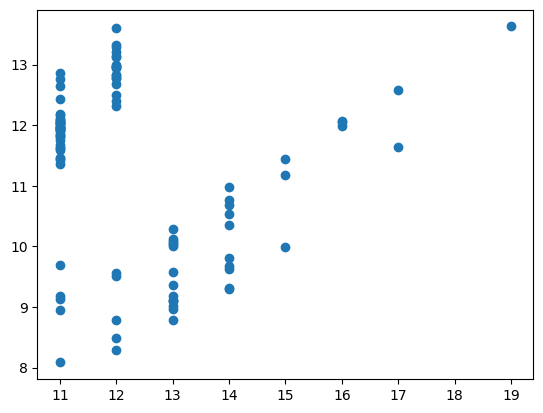

In [245]:
plt.scatter(df_cleaned['len'], df_cleaned['time'])

На самом деле, все не совсем так. Из-за того, что в алгоритме есть проверка на полное совпадение (а таких случаев большинство), поиск прерывается в случайный момент, поэтому мы не можем оценить скорость роста времени в зависимости от длины строки, хотя видим, что рост времени в зависимости от длины строки прослеживается

# <center> Задание 2</center>

Для при нормализации регистра текста, который был введён в верхнем регистре могут возникнуть следующие задачи, которые необходимо решить:
- Простановка загравных букв в начале предложений и цитатах
- Простановка заглавных букв в именах собственных
- Написаие аббревиатур заглавными буквами
- Написание кодов/номеров

Рассмотрим детальнее каждую из задач:

**Заглавные буквы в начале предложений и цитатах.** 

Приведем весь текст к нижнему регистру. Если предложения оформлены правильно (в конце предложения поставлена точка, после точки пробел и начало нового предложения), согласно нормам русского языка, то задача является несложной. Необходимо просто находить точки, и символы через 1 после точки приводить к верхнему регистру. Если мы рассматриваем рукописный текст, то, конечно, пользователи не всегда пишут правильно. Возможны несколько вариантов:
- Отсутствие точки
- Отсутствие пробела между точкой и началом следующего предложения
- Наличие нескольких пробелов между точкой и началом следующего предложения.


Цитирование можно обнаружить по наличию кавычек, первая буква, находящаяся в кавычках будет заглавной. Случай, когда автор пишет в кавычках слово не в своем значении или неформальное слово не учтен. Фиксация таких случаев должна осуществляться с помощью анализа контекста предложения и его эмоциональной окраски.


Проблему с отсутствием точки, мне кажется, невозможно решить без инструментов текстового анализа, в частности необходимо понимать контекст, чтобы разделить текст на предложения. Возможно учитывать наличие вводных слов, которые сигнализируют о начале нового предложения или, например, написание одного и того же слова два раза подряд (пример: Он взял яблоко. Яблоко было вкусным). Решение первых двух из выше перечисленных мной проблем, а также проблемы цитирования, приведу ниже:

In [206]:
import re

In [227]:
def norm1(text):
    #заменим несколько пробелов, если они есть, на один
    text = re.sub(r'\s+', ' ', text)
    
    #Вставим пробел после точки, если он отсутствует
    text = re.sub(r'\.(?=[A-ЯЁ])', '. ', text)
    
    #все слова к нижнему регистру
    text = text.lower()
    
    #приведем к верхнему регистру слова, начинающиеся с буквы и стоящие после точки и пробела
    text = re.sub(r'(^[а-яё])|(\.\s*[а-яё])', lambda pat: pat.group().upper(), text)
    
    #приведем к верхнему регистру первую букву после одинарных или двойных кавычек
    text = re.sub(r'(["\'][а-яё])', lambda pat: pat.group().upper(), text)
    return text

In [215]:
txt = '"НЕ ОТКЛАДЫВАЙ ДО ЗАВТРА, ЧТО МОЖЕШЬ СДЕЛАТЬ СЕГОДНЯ", сказал он.НЕ ЗАСТАВЛЯЙ ДРУГОГО ДЕЛАТЬ ТО, ЧТО МОЖЕШЬ СДЕЛАТЬ САМ.    ГОРДОСТЬ ОБХОДИТСЯ ДОРОЖЕ, ЧЕМ ВСЁ, ЧТО НУЖНО ДЛЯ ЕДЫ, ПИТЬЯ, ЖИЛИЩА, ОДЕЖДЫ.'
norm1(txt)

'"Не откладывай до завтра, что можешь сделать сегодня", сказал он. Не заставляй другого делать то, что можешь сделать сам. Гордость обходится дороже, чем всё, что нужно для еды, питья, жилища, одежды.'

**Простановка заглавных букв в именах собственных и аббревиатурах**

Для решения этой проблемы также стоит прибегнуть к инструментам текстового анализа, а также небоходимо иметь списки самых популярных имён и аббревиатур. С помощью таких списков можно сразу вычленять из текста имена/аббревиатуры и это может помочь в большинстве случаев. Текстовый анализ необходим для решения следующих проблем:
- Имя Вера является именем собственным, но слово вера - обычное существительное. Необходимо в зависимости от контекста, опередять, перед нами имя собственное или нет. Это можно реализовать с помощью алгоритма Word2Vec, который может оценить, подходит ли данному слову определенный контекст.
- В тексте могут встречаться, например, названия иностранных компаний, например Apple, которые должны писаться с заглавной буквы. Можно, учитывая контекст, обращать внимание и на слова, написанные на другом явзыке. Также некоторые компании имеют в своем названии символ "&", например Procter&Gamble, можно отдельно обращать внимание на наличие этого символа в словах.
- Аналогично, можно определить слово сто как минимальное трехзначное число, а можно как СТО (система технического обслуживания), обнаружение таких слов тоже требует текстового анализа и "статус" слова должен определяться, исходя из контекста. 
- Обычно аббревиатуры не похожи на привычные человеку слова, они редко могут быть разделены на слоги из-за малого количества гласных, поэтому как вариант, аббревиатуру можно вычислить по небольшой длине слова, а также по большой концентрации согласных. В поиске таких слов можно использовать специально обученную нейросеть.

**Написание кодов/номеров**

В тексте могут встречаться технические коды/номера модели (ЭВМ-67), которые могут содержать в себе цифры, что является одним из наиболее показательных признаков, по которым можно обнаружать такие слова, также в данных словах могут встречаться специальные символы, например "№" и "-". Такие номера нужно переводить в верхний регистр. Приведу реализацию такого алгоритма, использовав регулярные выражения.

In [228]:
def norm2(text):
    #заменим несколько пробелов, если они есть, на один
    text = re.sub(r'\s+', ' ', text)
    
    #Вставим пробел после точки, если он отсутствует
    text = re.sub(r'\.(?=[A-ЯЁ])', '. ', text)
    
    #все слова к нижнему регистру
    text = text.lower()
    
    #приведем к верхнему регистру слова, начинающиеся с буквы и стоящие после точки и пробела
    text = re.sub(r'(^[а-яё])|(\.\s*[а-яё])', lambda pat: pat.group().upper(), text)
    
    #приведем к верхнему регистру первую букву после одинарных или двойных кавычек
    text = re.sub(r'(["\'][а-яё])', lambda pat: pat.group().upper(), text)
    
    #приведем к верхнему регистру технические коды/номера модели
    text = re.sub(r'\b[A-ЯЁа-яё0-9№-]+\b', lambda pat: pat.group().upper() if any(char.isdigit() for char in pat.group()) else pat.group(), text)
    return text

In [229]:
txt = 'ЭТО БЫЛА МОдЕЛЬ ЭВМ-67, НА ЕЕ СЕРИЙНЫЙ НОМЕР - №12345'
norm2(txt)

'Это была модель ЭВМ-67, на ее серийный номер - №12345'